In [24]:
import pandas as pd
import numpy as np
import numerapi
import sklearn.linear_model
import matplotlib.pylab as plt

from datetime import timedelta
import tqdm

In [25]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [26]:
%%time
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
training_data.head()

Wall time: 22.3 s


,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [27]:
# download the latest tournament dataset (takes around 30s)
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [28]:
# find only the feature columns
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]

In [29]:
# select those columns out of the training dataset
training_features = training_data[feature_cols]

In [30]:
target = training_data['target']

In [31]:
eras = training_data['era']
eras_live = tournament_data.era

In [32]:
N_ERAS_IN_FOLD = 12
N_FOLDS = int(len(eras.unique()) / N_ERAS_IN_FOLD)

eras2_binned = []
current_era = 1
thresh_era_limit = N_ERAS_IN_FOLD
for era in eras:
    era_num = int(era.split('era')[-1])
    if era_num <= thresh_era_limit:
        eras2_binned.append(current_era)
    else:
        current_era += 1
        thresh_era_limit += N_ERAS_IN_FOLD
        eras2_binned.append(current_era)

In [33]:
validation_ids = tournament_data.data_type=='validation'

### Feature importance

In [34]:
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import log_loss, accuracy_score
from sklearn import model_selection

from scipy.cluster.hierarchy import linkage, fcluster
from itertools import product

In [35]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [36]:
REFERENCES = [0.0, 0.25, 0.5, 0.75, 1.0]

In [37]:
def get_base_model(cw = {0: 1,
                          1: 1.1,
                          2: 1,
                          3: 1.1,
                          4: 1
                        }):
    return RidgeClassifier(alpha = 1, 
                           class_weight = cw
                                    )
    
def ridge_classifier_2single_prediction(model, X, temperature = 1.0):
    try:
        predictions_proba_mean = model.decision_function(X)
    except:
        predictions_proba_mean = model.predict_proba(X)
    predictions = np.argmax(predictions_proba_mean, axis=1)
    predictions_proba = np.array([np.exp(di / temperature) / np.sum(np.exp(di / temperature)) for di in predictions_proba_mean])
    single_score_predictions = np.array(
            [
                sum(REFERENCES[i] * x[i] for i in range(len(REFERENCES))) for x in predictions_proba
            ]
        )

    return single_score_predictions

def train_model(X_train, Y_train, model = None):
    if model == None:
        model_i = get_base_model()
    else:
        model_i = model
    model_i.fit(X_train, Y_train)
    return model_i

def calculate_score(train_data, predictions, eras):

    ns = numerai_score(train_data, pd.Series(predictions))
    cs = correlation_score(train_data, pd.Series(predictions))

    df2 = pd.DataFrame(
        {
            "era": eras,
            "preds": predictions,
            "target": train_data
        }
    )

    scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

    per_era_score, per_era_std = scores_per_era.mean(), scores_per_era.std()
    sharpe_era_score = scores_per_era.mean() / scores_per_era.std()
    return ns, cs, per_era_score, per_era_std, sharpe_era_score


def ridge2probas(model, X, temperature = 1.0):
    try:
        predictions_proba_mean = model.decision_function(X)
    except:
        predictions_proba_mean = model.predict_proba(X)
    predictions = np.argmax(predictions_proba_mean, axis=1)
    predictions_proba = np.array([np.exp(di / temperature) / np.sum(np.exp(di / temperature)) for di in predictions_proba_mean])
    return predictions_proba

def softmax2singlescore(predictions_proba):
    single_score_predictions = np.array(
            [
                sum(REFERENCES[i] * x[i] for i in range(len(REFERENCES))) for x in predictions_proba
            ]
        )

    return single_score_predictions

# Baseline

In [38]:
validation_ids = tournament_data.data_type=='validation'
tournament_data = tournament_data[validation_ids]

In [39]:
le = LabelEncoder()

X = training_features
Y = le.fit_transform(target)
Y_nmr = target

In [40]:
X_test = tournament_data[feature_cols]
Y_test = le.fit_transform(tournament_data.target)
Y_nmr_test = tournament_data.target
test_eras = tournament_data.era

In [41]:
clf = get_base_model()
clf.fit(X, Y)
pred_c = clf.predict(X_test)
pred = ridge_classifier_2single_prediction(clf, X_test)

In [42]:
print(classification_report(pred_c, Y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.01      0.23      0.01       709
           2       0.99      0.50      0.67    135810
           3       0.01      0.23      0.02      1260
           4       0.00      0.00      0.00         0

    accuracy                           0.50    137779
   macro avg       0.20      0.19      0.14    137779
weighted avg       0.98      0.50      0.66    137779



C:\Users\ws-111\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


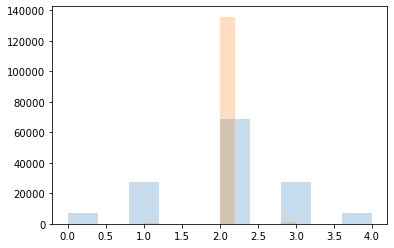

In [43]:
plt.figure()
plt.hist(Y_test, alpha = 0.25)
plt.hist(pred_c, alpha = 0.25)
plt.show()

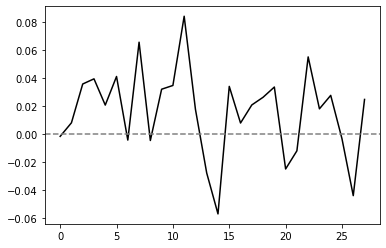

corr_spearman    = 0.016
corr_pearson     = 0.015
per_era_avg_corr = 0.016
per_era_std_corr = 0.031
sharpe_era_corr  = 0.51


In [44]:
ns_bs = numerai_score(Y_nmr_test, pd.Series(pred))
cs_bs = correlation_score(Y_nmr_test, pd.Series(pred))

df2 = pd.DataFrame(
    {
        "era": test_eras,
        "preds": pred,
        "target": Y_nmr_test
    }
)

scores_per_era_bs = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

per_era_score, per_era_std = scores_per_era_bs.mean(), scores_per_era_bs.std()
sharpe_era_score = scores_per_era_bs.mean() / scores_per_era_bs.std()

plt.figure()
plt.plot(scores_per_era_bs.values, color = 'black')
plt.axhline(0.0, ls = '--', color = 'grey')
plt.show()
print('corr_spearman    = {}'.format(round(ns_bs, 3)))
print('corr_pearson     = {}'.format(round(cs_bs, 3)))
print('per_era_avg_corr = {}'.format(round(per_era_score, 3)))
print('per_era_std_corr = {}'.format(round(per_era_std, 3)))
print('sharpe_era_corr  = {}'.format(round(sharpe_era_score, 3)))

In [45]:
def featImpMDA(X, y, cv, eras_groups):

    cvGen = model_selection.GroupKFold(cv)
    X_old = X.copy()
    scr0,scr1=pd.Series(), pd.DataFrame(columns=X.columns)

    for i, (train,test) in tqdm.tqdm(enumerate(cvGen.split(X=X, groups = eras_groups))):


        X0, y0 = X.iloc[train, :], y[train]
        X1, y1 = X.iloc[test, :], y[test] 
        # eras_test = pd.Series(eras2_binned).iloc[test]
        eras_test = pd.Series(eras_groups).iloc[test]

        clf = get_base_model()
        clf.fit(X=X0,y=y0)
        y1 = le.inverse_transform(y1)

        # pred = fit.predict(X1)
        pred = ridge_classifier_2single_prediction(clf, X1)

        # scr0.loc[i]=correlation_score(y1,pred)
        sharpes_metrics = calculate_score(y1, pred, eras_test)
        scr0.loc[i] = sharpes_metrics[0]

        for j in X.columns:

            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column

            pred_shuffled = ridge_classifier_2single_prediction(clf, X1_)

            # scr1.loc[i,j]=correlation_score(y1,pred_shuffled)
            sharpes_metrics_shuffled = calculate_score(y1, pred_shuffled, eras_test)
            scr1.loc[i,j] = sharpes_metrics_shuffled[0]

    imp=(-scr1).add(scr0,axis=0)
    imp=imp/(1.-scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    return imp,scr0.mean()

## Selecting importances features

In [46]:
X_FOR_FEATURE_IMPORTANCE = X[:int(len(X)/2)]
Y_FOR_FEATURE_IMPORTANCE = Y[:int(len(Y)/2)]
ERAS_FOR_FI = eras2_binned[:int(len(eras2_binned)/2)]

In [47]:
importances, oos = featImpMDA(X=X_FOR_FEATURE_IMPORTANCE, 
                               y=Y_FOR_FEATURE_IMPORTANCE,
                               cv = 5,
                               eras_groups = ERAS_FOR_FI)

<ipython-input-45-9c60892d4745>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scr0,scr1=pd.Series(), pd.DataFrame(columns=X.columns)
5it [18:11, 218.24s/it]


In [48]:
importances

,mean,std
feature_intelligence1,0.001877,0.000402
feature_intelligence2,0.003747,0.001630
feature_intelligence3,0.001444,0.000628
feature_intelligence4,0.001323,0.000583
feature_intelligence5,0.000409,0.000370
...,...,...
feature_wisdom42,0.000028,0.000229
feature_wisdom43,0.000258,0.000145
feature_wisdom44,-0.000031,0.000168
feature_wisdom45,0.000577,0.000313


In [27]:
# importances_more_zero = importances[importances['mean'] - importances['std']  > 0]
# importances_more_zero['mean_std_diff'] = importances_more_zero['mean'] - importances_more_zero['std']
importances_more_zero = importances[importances['mean']  > 0]
# importances_more_zero = importances.sort_values('mean')[::-1]

In [28]:
DOWN, UP = 0, 100
COLUMN = 'mean'

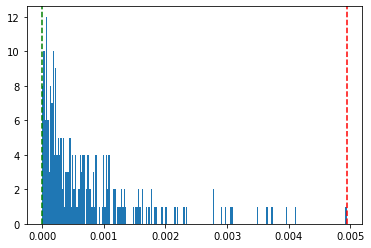

In [29]:
plt.figure()
plt.hist(importances_more_zero[COLUMN].values, bins = len(importances_more_zero))
plt.axvline(np.percentile(importances_more_zero[COLUMN].values, UP), ls = '--', color = 'red')
plt.axvline(np.percentile(importances_more_zero[COLUMN].values, DOWN), ls = '--', color = 'green')
plt.show()

In [30]:
up_limit = np.percentile(importances_more_zero[COLUMN].values, UP)
bot_limit = np.percentile(importances_more_zero[COLUMN].values, DOWN)
bot_limit, up_limit

(9.336058443071271e-07, 0.0049383417423165855)

In [31]:
mask = (importances_more_zero[COLUMN] < up_limit) & (importances_more_zero[COLUMN] > bot_limit)
IMPORTANT_FEATURES = importances_more_zero[mask].index.tolist()
len(IMPORTANT_FEATURES)

233

# Re-Balance the Class Weights

In [32]:
X_FOR_CV = X[int(len(X)/2):]
Y_FOR_CV = Y[int(len(Y)/2):]

ERAS_CV = training_data[int(len(training_data)/2):].era
ERAS_CV = ERAS_CV.apply(lambda x: 'era' + str(int(x[3:])-63))
Y_NMR_CV = Y_nmr[int(len(Y_nmr)/2):]

In [33]:
model_t = get_base_model(   
        cw = {
            0: 1,
            1: 1.1,
            2: 1,
            3: 1.1,
            4: 1
        }
    )
model_t = train_model(X_FOR_CV[IMPORTANT_FEATURES], Y_FOR_CV, model_t)
pred = model_t.predict(X_FOR_CV[IMPORTANT_FEATURES])

In [34]:
pred

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [35]:
print(classification_report(pred, Y_FOR_CV))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.21      0.01      1033
           2       0.99      0.50      0.67    247248
           3       0.01      0.24      0.02      2623
           4       0.00      0.00      0.00         0

    accuracy                           0.50    250904
   macro avg       0.20      0.19      0.14    250904
weighted avg       0.98      0.50      0.66    250904



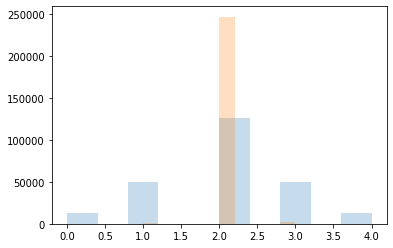

In [36]:
plt.figure()
plt.hist(Y_FOR_CV, alpha = 0.25)
plt.hist(pred, alpha = 0.25)
plt.show()

# Cross-validation

In [43]:
class PurgeCVByEras(model_selection.BaseCrossValidator):

    def __init__(self, eras, n_eras_train, n_eras_test, embargo, era_prefix = 'era'):
        self.eras = eras
        self.n_eras = len(eras.unique())
        self.era_prefix = era_prefix
        self.n_eras_train = n_eras_train
        self.n_eras_test = n_eras_test
        self.embargo = embargo

    def get_indices_of_era(self, era):
        era_str = self.era_prefix + str(era)
        return self.eras.index[self.eras == era_str].tolist()

    def split(self, X=None, y=None, groups=None):
        for i in range(0, self.n_eras, (self.n_eras_train + self.n_eras_test + self.embargo)):
            train_eras = [i+n for n in range(self.n_eras_train)]
            test_eras = [i+m+self.n_eras_train+self.embargo for m in range(self.n_eras_test)]
            train_indices = []

            test_limit = 0
            if max(train_eras) >= self.n_eras:
                break
            elif max(test_eras) >= self.n_eras:
                max_index = test_eras.index(max(test_eras))
                test_eras = test_eras[:max_index]

            for e in train_eras:
                e_indices = self.get_indices_of_era(e)
                train_indices.extend(e_indices)

            test_indices = []
            for e in test_eras:
                e_indices = self.get_indices_of_era(e)
                test_indices.extend(e_indices)

            yield(train_indices, test_indices)        

    def get_n_splits(self):
        return len(range(0, self.n_eras, (self.n_eras_train + self.n_eras_test + self.embargo)))

In [44]:
class BlockingTimeSeriesSplit():

    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [3]:
from sklearn.decomposition import PCA

In [4]:
import catboost

In [ ]:
alpha, beta = 1, 1 # scaling of the tanh function (the higher - the most "rough")
def temperature_function(x, alpha=alpha, beta=beta, mi=0.01, ma=10):
    return np.clip(alpha * -np.tanh(x * beta) + 1, mi, ma)

def train_meta_labeler(X, Y_proba, Y_target):
    meta_labels = np.array(
          [p == t for p, t in zip(np.argmax(Y_proba, axis=1), Y_target)], dtype = np.int16
      )
    model_meta = CatBoostClassifier(
          custom_loss=['Logloss'],
          random_seed=42,
          iterations = 25,
          logging_level = 'Silent'
      )
    model_meta.fit(
        X, meta_labels
    )
    meta_predictions = model_meta.predict(X)
    meta_predictions_proba = model_meta.predict_proba(X)
    mean_meta_prob = np.mean(meta_predictions_proba[:, 1])
    return model_meta, mean_meta_prob

def normal_labels_to_meta_labels(predictions_proba_live, predictions_proba_live_meta, mean_meta_prob):
    predictions_proba_live_comb = []
    for pred_proba_live, pred_proba_live_meta in zip(predictions_proba_live, predictions_proba_live_meta[:, 1]):
        x = pred_proba_live_meta - mean_meta_prob
        temperature = temperature_function(x) # calculation of the trust temperature
        res = np.exp(pred_proba_live / temperature) / np.sum(np.exp(pred_proba_live / temperature)) # rescaling to sum up to 1.0
        predictions_proba_live_comb.append(res)
    predictions_proba_live_comb = np.array(predictions_proba_live_comb)
    return predictions_proba_live_comb

In [ ]:
model_i = get_base_model(cw = {
                        0: 1,
                        1: 1.1,
                        2: 1,
                        3: 1.1,
                        4: 1
                    })
model_i = train_model(X_train, Y_train, model_i)
single_score_predictions = ridge_classifier_2single_prediction(model_i, X_test)
Y_prob = model_i.decision_function(X_train)